<a href="https://colab.research.google.com/github/yghebre6/Swift-for-TensorFlow/blob/main/Inception_v3.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Inception-v3 in S4TF

## Configure imports

In [ ]:
%install '.package(url: "https://github.com/tensorflow/swift-models", .branch("tensorflow-0.11"))' Datasets
print("\u{001B}[2J")

In [ ]:
import Datasets
import ImageClassificationModels
import TensorFlow
import Python
import Foundation

2020-11-30 13:57:14.231000: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


In [ ]:
%include "EnableIPythonDisplay.swift"
IPythonDisplay.shell.enable_matplotlib("inline")

let plt = Python.import("matplotlib.pyplot")
let np  = Python.import("numpy")
let h5py = Python.import("h5py")
let path = Python.import("os.path")
let tf = Python.import("tensorflow")

2020-11-30 13:57:25.752508: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudart.so.10.1


## Model

### Convolution + BatchNorm layer

In [ ]:
struct Conv2DBN: Layer {
    var conv: Conv2D<Float>
    var batch_norm: BatchNorm<Float>
    
    public init(filterShape: (Int, Int, Int, Int), strides: (Int, Int), padding: Padding) {
      self.conv = Conv2D<Float>(filterShape: filterShape, strides: strides, padding: padding, activation: relu, useBias: false)
      self.batch_norm = BatchNorm(axis: -1,
                        momentum: 0.99,
                        offset: Tensor(zeros: [filterShape.3]),
                        scale: Tensor(ones: [filterShape.3]),
                        epsilon: 0.001,
                        runningMean: Tensor(zeros: [filterShape.3]),
                        runningVariance: Tensor(ones: [filterShape.3]))
    }

    @differentiable
    func callAsFunction(_ input: Tensor<Float>) -> Tensor<Float> {
      var output = conv(input)
      output = batch_norm(output)
      return output
    }
}

### Inception-v3

Architecture as described here https://arxiv.org/pdf/1512.00567.pdf

In [ ]:
struct InceptionV3: Layer {

    var conv1 = Conv2DBN(filterShape: (3, 3, 3, 32), strides: (2, 2), padding: .valid)
    var conv2 = Conv2DBN(filterShape: (3, 3, 32, 32), strides: (1, 1), padding: .valid)
    var conv3 = Conv2DBN(filterShape: (3, 3, 32, 64), strides: (1, 1), padding: .same)
    var max_pool1 = MaxPool2D<Float>(poolSize: (3, 3), strides: (2, 2), padding: .valid)
    var conv4 = Conv2DBN(filterShape: (1, 1, 64, 80), strides: (1, 1), padding: .valid)
    var conv5 = Conv2DBN(filterShape: (3, 3, 80, 192), strides: (1, 1), padding: .valid)
    var max_pool2 = MaxPool2D<Float>(poolSize: (3, 3), strides: (2, 2), padding: .valid)

    var inception_5a_branch0_1x1 = Conv2DBN(filterShape: (1, 1, 192, 64), strides: (1, 1), padding: .same)
    var inception_5a_branch0_3x3_1 = Conv2DBN(filterShape: (3, 3, 64, 96), strides: (1, 1), padding: .same)
    var inception_5a_branch0_3x3_2 = Conv2DBN(filterShape: (3, 3, 96, 96), strides: (1, 1), padding: .same)
    var inception_5a_branch1_1x1 = Conv2DBN(filterShape: (1, 1, 192, 48), strides: (1, 1), padding: .same)
    var inception_5a_branch1_5x5 = Conv2DBN(filterShape: (5, 5, 48, 64), strides: (1, 1), padding: .same)
    var inception_5a_branch2_pool = AvgPool2D<Float>(poolSize: (3, 3), strides: (1, 1), padding: .same)
    var inception_5a_branch2_1x1 = Conv2DBN(filterShape: (1, 1, 192, 32), strides: (1, 1), padding: .same)
    var inception_5a_branch3_1x1 = Conv2DBN(filterShape: (1, 1, 192, 64), strides: (1, 1), padding: .same)

    var inception_5b_branch0_1x1 = Conv2DBN(filterShape: (1, 1, 256, 64), strides: (1, 1), padding: .same)
    var inception_5b_branch0_3x3_1 = Conv2DBN(filterShape: (3, 3, 64, 96), strides: (1, 1), padding: .same)
    var inception_5b_branch0_3x3_2 = Conv2DBN(filterShape: (3, 3, 96, 96), strides: (1, 1), padding: .same)
    var inception_5b_branch1_1x1 = Conv2DBN(filterShape: (1, 1, 256, 48), strides: (1, 1), padding: .same)
    var inception_5b_branch1_5x5 = Conv2DBN(filterShape: (5, 5, 48, 64), strides: (1, 1), padding: .same)
    var inception_5b_branch2_pool = AvgPool2D<Float>(poolSize: (3, 3), strides: (1, 1), padding: .same)
    var inception_5b_branch2_1x1 = Conv2DBN(filterShape: (1, 1, 256, 64), strides: (1, 1), padding: .same)
    var inception_5b_branch3_1x1 = Conv2DBN(filterShape: (1, 1, 256, 64), strides: (1, 1), padding: .same)

    var inception_5c_branch0_1x1 = Conv2DBN(filterShape: (1, 1, 288, 64), strides: (1, 1), padding: .same)
    var inception_5c_branch0_3x3_1 = Conv2DBN(filterShape: (3, 3, 64, 96), strides: (1, 1), padding: .same)
    var inception_5c_branch0_3x3_2 = Conv2DBN(filterShape: (3, 3, 96, 96), strides: (1, 1), padding: .same)
    var inception_5c_branch1_1x1 = Conv2DBN(filterShape: (1, 1, 288, 48), strides: (1, 1), padding: .same)
    var inception_5c_branch1_5x5 = Conv2DBN(filterShape: (5, 5, 48, 64), strides: (1, 1), padding: .same)
    var inception_5c_branch2_pool = AvgPool2D<Float>(poolSize: (3, 3), strides: (1, 1), padding: .same)
    var inception_5c_branch2_1x1 = Conv2DBN(filterShape: (1, 1, 288, 64), strides: (1, 1), padding: .same)
    var inception_5c_branch3_1x1 = Conv2DBN(filterShape: (1, 1, 288, 64), strides: (1, 1), padding: .same)

    var inception_6a_branch0_1x1 = Conv2DBN(filterShape: (1, 1, 288, 64), strides: (1, 1), padding: .same)
    var inception_6a_branch0_3x3_1 = Conv2DBN(filterShape: (3, 3, 64, 96), strides: (1, 1), padding: .same)
    var inception_6a_branch0_3x3_2 = Conv2DBN(filterShape: (3, 3, 96, 96), strides: (2, 2), padding: .valid)
    var inception_6a_branch1_3x3 = Conv2DBN(filterShape: (3, 3, 288, 384), strides: (2, 2), padding: .valid)
    var inception_6a_branch2_pool = MaxPool2D<Float>(poolSize: (3, 3), strides: (2, 2), padding: .valid)

    var inception_6b_branch0_1x1 = Conv2DBN(filterShape: (1, 1, 768, 128), strides: (1, 1), padding: .same)
    var inception_6b_branch0_7x1_1 = Conv2DBN(filterShape: (7, 1, 128, 128), strides: (1, 1), padding: .same)
    var inception_6b_branch0_1x7_1 = Conv2DBN(filterShape: (1, 7, 128, 128), strides: (1, 1), padding: .same)
    var inception_6b_branch0_7x1_2 = Conv2DBN(filterShape: (7, 1, 128, 128), strides: (1, 1), padding: .same)
    var inception_6b_branch0_1x7_2 = Conv2DBN(filterShape: (1, 7, 128, 192), strides: (1, 1), padding: .same)
    var inception_6b_branch1_1x1 = Conv2DBN(filterShape: (1, 1, 768, 128), strides: (1, 1), padding: .same)
    var inception_6b_branch1_1x7_1 = Conv2DBN(filterShape: (1, 7, 128, 128), strides: (1, 1), padding: .same)
    var inception_6b_branch1_7x1_1 = Conv2DBN(filterShape: (7, 1, 128, 192), strides: (1, 1), padding: .same)
    var inception_6b_branch2_pool = AvgPool2D<Float>(poolSize: (3, 3), strides: (1, 1), padding: .same)
    var inception_6b_branch2_1x1 = Conv2DBN(filterShape: (1, 1, 768, 192), strides: (1, 1), padding: .same)
    var inception_6b_branch3_1x1 = Conv2DBN(filterShape: (1, 1, 768, 192), strides: (1, 1), padding: .same)

    var inception_6c_branch0_1x1 = Conv2DBN(filterShape: (1, 1, 768, 160), strides: (1, 1), padding: .same)
    var inception_6c_branch0_7x1_1 = Conv2DBN(filterShape: (7, 1, 160, 160), strides: (1, 1), padding: .same)
    var inception_6c_branch0_1x7_1 = Conv2DBN(filterShape: (1, 7, 160, 160), strides: (1, 1), padding: .same)
    var inception_6c_branch0_7x1_2 = Conv2DBN(filterShape: (7, 1, 160, 160), strides: (1, 1), padding: .same)
    var inception_6c_branch0_1x7_2 = Conv2DBN(filterShape: (1, 7, 160, 192), strides: (1, 1), padding: .same)
    var inception_6c_branch1_1x1 = Conv2DBN(filterShape: (1, 1, 768, 160), strides: (1, 1), padding: .same)
    var inception_6c_branch1_1x7_1 = Conv2DBN(filterShape: (1, 7, 160, 160), strides: (1, 1), padding: .same)
    var inception_6c_branch1_7x1_1 = Conv2DBN(filterShape: (7, 1, 160, 192), strides: (1, 1), padding: .same)
    var inception_6c_branch2_pool = AvgPool2D<Float>(poolSize: (3, 3), strides: (1, 1), padding: .same)
    var inception_6c_branch2_1x1 = Conv2DBN(filterShape: (1, 1, 768, 192), strides: (1, 1), padding: .same)
    var inception_6c_branch3_1x1 = Conv2DBN(filterShape: (1, 1, 768, 192), strides: (1, 1), padding: .same)

    var inception_6d_branch0_1x1 = Conv2DBN(filterShape: (1, 1, 768, 160), strides: (1, 1), padding: .same)
    var inception_6d_branch0_7x1_1 = Conv2DBN(filterShape: (7, 1, 160, 160), strides: (1, 1), padding: .same)
    var inception_6d_branch0_1x7_1 = Conv2DBN(filterShape: (1, 7, 160, 160), strides: (1, 1), padding: .same)
    var inception_6d_branch0_7x1_2 = Conv2DBN(filterShape: (7, 1, 160, 160), strides: (1, 1), padding: .same)
    var inception_6d_branch0_1x7_2 = Conv2DBN(filterShape: (1, 7, 160, 192), strides: (1, 1), padding: .same)
    var inception_6d_branch1_1x1 = Conv2DBN(filterShape: (1, 1, 768, 160), strides: (1, 1), padding: .same)
    var inception_6d_branch1_1x7_1 = Conv2DBN(filterShape: (1, 7, 160, 160), strides: (1, 1), padding: .same)
    var inception_6d_branch1_7x1_1 = Conv2DBN(filterShape: (7, 1, 160, 192), strides: (1, 1), padding: .same)
    var inception_6d_branch2_pool = AvgPool2D<Float>(poolSize: (3, 3), strides: (1, 1), padding: .same)
    var inception_6d_branch2_1x1 = Conv2DBN(filterShape: (1, 1, 768, 192), strides: (1, 1), padding: .same)
    var inception_6d_branch3_1x1 = Conv2DBN(filterShape: (1, 1, 768, 192), strides: (1, 1), padding: .same)

    var inception_6e_branch0_1x1 = Conv2DBN(filterShape: (1, 1, 768, 192), strides: (1, 1), padding: .same)
    var inception_6e_branch0_7x1_1 = Conv2DBN(filterShape: (7, 1, 192, 192), strides: (1, 1), padding: .same)
    var inception_6e_branch0_1x7_1 = Conv2DBN(filterShape: (1, 7, 192, 192), strides: (1, 1), padding: .same)
    var inception_6e_branch0_7x1_2 = Conv2DBN(filterShape: (7, 1, 192, 192), strides: (1, 1), padding: .same)
    var inception_6e_branch0_1x7_2 = Conv2DBN(filterShape: (1, 7, 192, 192), strides: (1, 1), padding: .same)
    var inception_6e_branch1_1x1 = Conv2DBN(filterShape: (1, 1, 768, 192), strides: (1, 1), padding: .same)
    var inception_6e_branch1_1x7_1 = Conv2DBN(filterShape: (1, 7, 192, 192), strides: (1, 1), padding: .same)
    var inception_6e_branch1_7x1_1 = Conv2DBN(filterShape: (7, 1, 192, 192), strides: (1, 1), padding: .same)
    var inception_6e_branch2_pool = AvgPool2D<Float>(poolSize: (3, 3), strides: (1, 1), padding: .same)
    var inception_6e_branch2_1x1 = Conv2DBN(filterShape: (1, 1, 768, 192), strides: (1, 1), padding: .same)
    var inception_6e_branch3_1x1 = Conv2DBN(filterShape: (1, 1, 768, 192), strides: (1, 1), padding: .same)
    
    var aux_class_avg_pool = AvgPool2D<Float>(poolSize: (5, 5), strides: (3, 3), padding: .valid)
    var aux_class_conv = Conv2DBN(filterShape: (1, 1, 768, 128), strides: (1, 1), padding: .same)
    var aux_class_flatten = Flatten<Float>()
    var aux_class_fc = Dense<Float>(inputSize: 1152, outputSize: 10)

    var inception_7a_branch0_1x1 = Conv2DBN(filterShape: (1, 1, 768, 192), strides: (1, 1), padding: .same)
    var inception_7a_branch0_1x7 = Conv2DBN(filterShape: (1, 7, 192, 192), strides: (1, 1), padding: .same)
    var inception_7a_branch0_7x1 = Conv2DBN(filterShape: (7, 1, 192, 192), strides: (1, 1), padding: .same)
    var inception_7a_branch0_3x3 = Conv2DBN(filterShape: (3, 3, 192, 192), strides: (2, 2), padding: .valid)
    var inception_7a_branch1_1x1 = Conv2DBN(filterShape: (1, 1, 768, 192), strides: (1, 1), padding: .same)
    var inception_7a_branch1_3x3 = Conv2DBN(filterShape: (3, 3, 192, 320), strides: (2, 2), padding: .valid)
    var inception_7a_branch2_pool = MaxPool2D<Float>(poolSize: (3, 3), strides: (2, 2), padding: .valid)
    
    var inception_7b_branch0_1x1 = Conv2DBN(filterShape: (1, 1, 1280, 448), strides: (1, 1), padding: .same)
    var inception_7b_branch0_3x3 = Conv2DBN(filterShape: (3, 3, 448, 384), strides: (1, 1), padding: .same)
    var inception_7b_branch0_1x3 = Conv2DBN(filterShape: (1, 3, 384, 384), strides: (1, 1), padding: .same)
    var inception_7b_branch0_3x1 = Conv2DBN(filterShape: (3, 1, 384, 384), strides: (1, 1), padding: .same)
    var inception_7b_branch1_1x1 = Conv2DBN(filterShape: (1, 1, 1280, 384), strides: (1, 1), padding: .same)
    var inception_7b_branch1_1x3 = Conv2DBN(filterShape: (1, 3, 384, 384), strides: (1, 1), padding: .same)
    var inception_7b_branch1_3x1 = Conv2DBN(filterShape: (3, 1, 384, 384), strides: (1, 1), padding: .same)
    var inception_7b_branch2_pool = AvgPool2D<Float>(poolSize: (3, 3), strides: (1, 1), padding: .same)
    var inception_7b_branch2_1x1 = Conv2DBN(filterShape: (1, 1, 1280, 192), strides: (1, 1), padding: .same)
    var inception_7b_branch3_1x1 = Conv2DBN(filterShape: (1, 1, 1280, 320), strides: (1, 1), padding: .same)

    var inception_7c_branch0_1x1 = Conv2DBN(filterShape: (1, 1, 2048, 448), strides: (1, 1), padding: .same)
    var inception_7c_branch0_3x3 = Conv2DBN(filterShape: (3, 3, 448, 384), strides: (1, 1), padding: .same)
    var inception_7c_branch0_1x3 = Conv2DBN(filterShape: (1, 3, 384, 384), strides: (1, 1), padding: .same)
    var inception_7c_branch0_3x1 = Conv2DBN(filterShape: (3, 1, 384, 384), strides: (1, 1), padding: .same)
    var inception_7c_branch1_1x1 = Conv2DBN(filterShape: (1, 1, 2048, 384), strides: (1, 1), padding: .same)
    var inception_7c_branch1_1x3 = Conv2DBN(filterShape: (1, 3, 384, 384), strides: (1, 1), padding: .same)
    var inception_7c_branch1_3x1 = Conv2DBN(filterShape: (3, 1, 384, 384), strides: (1, 1), padding: .same)
    var inception_7c_branch2_pool = AvgPool2D<Float>(poolSize: (3, 3), strides: (1, 1), padding: .same)
    var inception_7c_branch2_1x1 = Conv2DBN(filterShape: (1, 1, 2048, 192), strides: (1, 1), padding: .same)
    var inception_7c_branch3_1x1 = Conv2DBN(filterShape: (1, 1, 2048, 320), strides: (1, 1), padding: .same)

    var avg_pool = AvgPool2D<Float>(poolSize: (5, 5), strides: (1, 1), padding: .valid)
    var flatten = Flatten<Float>()
    var dropout = Dropout<Float>(probability: 0.8)
    var fc = Dense<Float>(inputSize: 2048, outputSize: 10)

    @differentiable
    func callAsFunction(_ input: Tensor<Float>) -> Tensor<Float> {
        var output = conv1(input)
        output = conv2(output)
        output = conv3(output)
        output = max_pool1(output)
        output = conv4(output)
        output = conv5(output)
        output = max_pool2(output)

        var branch0 = inception_5a_branch0_1x1(output)
        branch0 = inception_5a_branch0_3x3_1(branch0)
        branch0 = inception_5a_branch0_3x3_2(branch0)
        var branch1 = inception_5a_branch1_1x1(output)
        branch1 = inception_5a_branch1_5x5(branch1)
        var branch2 = inception_5a_branch2_pool(output)
        branch2 = inception_5a_branch2_1x1(branch2)
        var branch3 = inception_5a_branch3_1x1(output)
        output = Tensor<Float>(concatenating: [branch0, branch1, branch2, branch3], alongAxis: 3)
        
        branch0 = inception_5b_branch0_1x1(output)
        branch0 = inception_5b_branch0_3x3_1(branch0)
        branch0 = inception_5b_branch0_3x3_2(branch0)
        branch1 = inception_5b_branch1_1x1(output)
        branch1 = inception_5b_branch1_5x5(branch1)
        branch2 = inception_5b_branch2_pool(output)
        branch2 = inception_5b_branch2_1x1(branch2)
        branch3 = inception_5b_branch3_1x1(output)
        output = Tensor<Float>(concatenating: [branch0, branch1, branch2, branch3], alongAxis: 3)

        branch0 = inception_5c_branch0_1x1(output)
        branch0 = inception_5c_branch0_3x3_1(branch0)
        branch0 = inception_5c_branch0_3x3_2(branch0)
        branch1 = inception_5c_branch1_1x1(output)
        branch1 = inception_5c_branch1_5x5(branch1)
        branch2 = inception_5c_branch2_pool(output)
        branch2 = inception_5c_branch2_1x1(branch2)
        branch3 = inception_5c_branch3_1x1(output)
        output = Tensor<Float>(concatenating: [branch0, branch1, branch2, branch3], alongAxis: 3)
        
        branch0 = inception_6a_branch0_1x1(output)
        branch0 = inception_6a_branch0_3x3_1(branch0)
        branch0 = inception_6a_branch0_3x3_2(branch0)
        branch1 = inception_6a_branch1_3x3(output)
        branch2 = inception_6a_branch2_pool(output)
        output = Tensor<Float>(concatenating: [branch0, branch1, branch2], alongAxis: 3)

        branch0 = inception_6b_branch0_1x1(output)
        branch0 = inception_6b_branch0_7x1_1(branch0)
        branch0 = inception_6b_branch0_1x7_1(branch0)
        branch0 = inception_6b_branch0_7x1_2(branch0)
        branch0 = inception_6b_branch0_1x7_2(branch0)
        branch1 = inception_6b_branch1_1x1(output)
        branch1 = inception_6b_branch1_1x7_1(branch1)
        branch1 = inception_6b_branch1_7x1_1(branch1)
        branch2 = inception_6b_branch2_pool(output)
        branch2 = inception_6b_branch2_1x1(branch2)
        branch3 = inception_6b_branch3_1x1(output)
        output = Tensor<Float>(concatenating: [branch0, branch1, branch2, branch3], alongAxis: 3)

        branch0 = inception_6c_branch0_1x1(output)
        branch0 = inception_6c_branch0_7x1_1(branch0)
        branch0 = inception_6c_branch0_1x7_1(branch0)
        branch0 = inception_6c_branch0_7x1_2(branch0)
        branch0 = inception_6c_branch0_1x7_2(branch0)
        branch1 = inception_6c_branch1_1x1(output)
        branch1 = inception_6c_branch1_1x7_1(branch1)
        branch1 = inception_6c_branch1_7x1_1(branch1)
        branch2 = inception_6c_branch2_pool(output)
        branch2 = inception_6c_branch2_1x1(branch2)
        branch3 = inception_6c_branch3_1x1(output)
        output = Tensor<Float>(concatenating: [branch0, branch1, branch2, branch3], alongAxis: 3)

        branch0 = inception_6d_branch0_1x1(output)
        branch0 = inception_6d_branch0_7x1_1(branch0)
        branch0 = inception_6d_branch0_1x7_1(branch0)
        branch0 = inception_6d_branch0_7x1_2(branch0)
        branch0 = inception_6d_branch0_1x7_2(branch0)
        branch1 = inception_6d_branch1_1x1(output)
        branch1 = inception_6d_branch1_1x7_1(branch1)
        branch1 = inception_6d_branch1_7x1_1(branch1)
        branch2 = inception_6d_branch2_pool(output)
        branch2 = inception_6d_branch2_1x1(branch2)
        branch3 = inception_6d_branch3_1x1(output)
        output = Tensor<Float>(concatenating: [branch0, branch1, branch2, branch3], alongAxis: 3)

        branch0 = inception_6e_branch0_1x1(output)
        branch0 = inception_6e_branch0_7x1_1(branch0)
        branch0 = inception_6e_branch0_1x7_1(branch0)
        branch0 = inception_6e_branch0_7x1_2(branch0)
        branch0 = inception_6e_branch0_1x7_2(branch0)
        branch1 = inception_6e_branch1_1x1(output)
        branch1 = inception_6e_branch1_1x7_1(branch1)
        branch1 = inception_6e_branch1_7x1_1(branch1)
        branch2 = inception_6e_branch2_pool(output)
        branch2 = inception_6e_branch2_1x1(branch2)
        branch3 = inception_6e_branch3_1x1(output)
        output = Tensor<Float>(concatenating: [branch0, branch1, branch2, branch3], alongAxis: 3)

        var aux_class_output = aux_class_avg_pool(output)
        aux_class_output = aux_class_conv(aux_class_output)
        aux_class_output = aux_class_flatten(aux_class_output)
        aux_class_output = aux_class_fc(aux_class_output)

        branch0 = inception_7a_branch0_1x1(output)
        branch0 = inception_7a_branch0_1x7(branch0)
        branch0 = inception_7a_branch0_7x1(branch0)
        branch0 = inception_7a_branch0_3x3(branch0)
        branch1 = inception_7a_branch1_1x1(output)
        branch1 = inception_7a_branch1_3x3(branch1)
        branch2 = inception_7a_branch2_pool(output)
        output = Tensor<Float>(concatenating: [branch0, branch1, branch2], alongAxis: 3)

        branch0 = inception_7b_branch0_1x1(output)
        branch0 = inception_7b_branch0_3x3(branch0)
        var branch0_0 = inception_7b_branch0_1x3(branch0)
        var branch0_1 = inception_7b_branch0_3x1(branch0)
        branch1 = inception_7b_branch1_1x1(output)
        var branch1_0 = inception_7b_branch1_1x3(branch1)
        var branch1_1 = inception_7b_branch1_3x1(branch1)
        branch2 = inception_7b_branch2_pool(output)
        branch2 = inception_7b_branch2_1x1(branch2)
        branch3 = inception_7b_branch3_1x1(output)
        output = Tensor<Float>(concatenating: [branch0_0, branch0_1, branch1_0, branch1_1, branch2, branch3], alongAxis: 3)

        branch0 = inception_7c_branch0_1x1(output)
        branch0 = inception_7c_branch0_3x3(branch0)
        branch0_0 = inception_7c_branch0_1x3(branch0)
        branch0_1 = inception_7c_branch0_3x1(branch0)
        branch1 = inception_7c_branch1_1x1(output)
        branch1_0 = inception_7c_branch1_1x3(branch1)
        branch1_1 = inception_7c_branch1_3x1(branch1)
        branch2 = inception_7c_branch2_pool(output)
        branch2 = inception_7c_branch2_1x1(branch2)
        branch3 = inception_7c_branch3_1x1(output)
        output = Tensor<Float>(concatenating: [branch0_0, branch0_1, branch1_0, branch1_1, branch2, branch3], alongAxis: 3)

        output = avg_pool(output)
        output = flatten(output)
        output = dropout(output)
        output = fc(output)

        if (Context.local.learningPhase == .training) {
          return 0.3 * aux_class_output + output
        } else {
          return output
        }
    }
}

### L2 Loss

In [ ]:
struct L2 {
    var l2_loss = Tensor<Float>(0, on: Device.default)
    var inception_v3: InceptionV3

    init(on device: Device = Device.default, inception_v3: InceptionV3) {
        self.l2_loss = Tensor<Float>(0, on: device)
        self.inception_v3 = inception_v3
    }

    mutating func loss() -> Tensor<Float> {
      var weight = inception_v3.conv1.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.conv2.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.conv3.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.conv4.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.conv5.conv.filter
      l2_loss += (weight * weight).sum()

      weight = inception_v3.inception_5a_branch0_1x1.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_5a_branch0_3x3_1.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_5a_branch0_3x3_2.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_5a_branch1_1x1.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_5a_branch1_5x5.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_5a_branch2_1x1.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_5a_branch3_1x1.conv.filter
      l2_loss += (weight * weight).sum()

      weight = inception_v3.inception_5b_branch0_1x1.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_5b_branch0_3x3_1.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_5b_branch0_3x3_2.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_5b_branch1_1x1.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_5b_branch1_5x5.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_5b_branch2_1x1.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_5b_branch3_1x1.conv.filter
      l2_loss += (weight * weight).sum()

      weight = inception_v3.inception_5c_branch0_1x1.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_5c_branch0_3x3_1.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_5c_branch0_3x3_2.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_5c_branch1_1x1.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_5c_branch1_5x5.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_5c_branch2_1x1.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_5c_branch3_1x1.conv.filter
      l2_loss += (weight * weight).sum()

      weight = inception_v3.inception_6a_branch0_1x1.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_6a_branch0_3x3_1.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_6a_branch0_3x3_2.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_6a_branch1_3x3.conv.filter
      l2_loss += (weight * weight).sum()

      weight = inception_v3.inception_6b_branch0_1x1.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_6b_branch0_7x1_1.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_6b_branch0_1x7_1.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_6b_branch0_7x1_2.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_6b_branch0_1x7_2.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_6b_branch1_1x1.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_6b_branch1_1x7_1.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_6b_branch1_7x1_1.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_6b_branch2_1x1.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_6b_branch3_1x1.conv.filter
      l2_loss += (weight * weight).sum()

      weight = inception_v3.inception_6c_branch0_1x1.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_6c_branch0_7x1_1.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_6c_branch0_1x7_1.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_6c_branch0_7x1_2.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_6c_branch0_1x7_2.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_6c_branch1_1x1.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_6c_branch1_1x7_1.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_6c_branch1_7x1_1.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_6c_branch2_1x1.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_6c_branch3_1x1.conv.filter
      l2_loss += (weight * weight).sum()

      weight = inception_v3.inception_6d_branch0_1x1.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_6d_branch0_7x1_1.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_6d_branch0_1x7_1.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_6d_branch0_7x1_2.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_6d_branch0_1x7_2.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_6d_branch1_1x1.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_6d_branch1_1x7_1.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_6d_branch1_7x1_1.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_6d_branch2_1x1.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_6d_branch3_1x1.conv.filter
      l2_loss += (weight * weight).sum()

      weight = inception_v3.inception_6e_branch0_1x1.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_6e_branch0_7x1_1.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_6e_branch0_1x7_1.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_6e_branch0_7x1_2.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_6e_branch0_1x7_2.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_6e_branch1_1x1.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_6e_branch1_1x7_1.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_6e_branch1_7x1_1.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_6e_branch2_1x1.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_6e_branch3_1x1.conv.filter
      l2_loss += (weight * weight).sum()

      weight = inception_v3.aux_class_conv.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.aux_class_fc.weight
      l2_loss += (weight * weight).sum()

      weight = inception_v3.inception_7a_branch0_1x1.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_7a_branch0_1x7.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_7a_branch0_7x1.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_7a_branch0_3x3.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_7a_branch1_1x1.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_7a_branch1_3x3.conv.filter
      l2_loss += (weight * weight).sum()

      weight = inception_v3.inception_7b_branch0_1x1.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_7b_branch0_3x3.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_7b_branch0_1x3.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_7b_branch0_3x1.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_7b_branch1_1x1.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_7b_branch1_1x3.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_7b_branch1_3x1.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_7b_branch2_1x1.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_7b_branch3_1x1.conv.filter
      l2_loss += (weight * weight).sum()

      weight = inception_v3.inception_7c_branch0_1x1.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_7c_branch0_3x3.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_7c_branch0_1x3.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_7c_branch0_3x1.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_7c_branch1_1x1.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_7c_branch1_1x3.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_7c_branch1_3x1.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_7c_branch2_1x1.conv.filter
      l2_loss += (weight * weight).sum()
      weight = inception_v3.inception_7c_branch3_1x1.conv.filter
      l2_loss += (weight * weight).sum()

      weight = inception_v3.fc.weight
      l2_loss += (weight * weight).sum()

      return l2_loss
    }
}

## Training + Inference

In [ ]:
struct Statistics {
    var device: Device = Device.default
    var epochs: Int = 0
    var avgEpochTrainTime: Double = 0
    var correctGuessCount = Tensor<Int32>(0, on: Device.default)
    var totalGuessCount = Tensor<Int32>(0, on: Device.default)
    var totalLoss = Tensor<Float>(0, on: Device.default)
    var batches: Int = 0
    var accuracy: Float { 
        Float(correctGuessCount.scalarized()) / Float(totalGuessCount.scalarized()) * 100 
    } 
    var averageLoss: Float { totalLoss.scalarized() / Float(batches) }

    var correctGuessCounts = Tensor<Int32>(0, on: Device.default)
    var totalGuessCounts = Tensor<Int32>(0, on: Device.default)
    var totalLosses = Tensor<Float>(0, on: Device.default)
    var accuracies = Tensor<Float>(0, on: Device.default)
    var averageLosses = Tensor<Float>(0, on: Device.default)

    init(on device: Device, epochs: Int) {
      self.device = device
      self.epochs = epochs
      correctGuessCount = Tensor<Int32>(0, on: device)
      totalGuessCount = Tensor<Int32>(0, on: device)
      totalLoss = Tensor<Float>(0, on: device)

      correctGuessCounts = Tensor<Int32>(zeros: [epochs], on: device)
      totalGuessCounts = Tensor<Int32>(zeros: [epochs], on: device)
      totalLosses = Tensor<Float>(zeros: [epochs], on: device)
      accuracies = Tensor<Float>(zeros: [epochs], on: device)
      averageLosses = Tensor<Float>(zeros: [epochs], on: device)
    }

    mutating func update(logits: Tensor<Float>, labels: Tensor<Float>, loss: Tensor<Float>) {
      let correct = logits.argmax(squeezingAxis: 1) .== labels.argmax(squeezingAxis: 1)
      correctGuessCount += Tensor<Int32>(correct).sum()
      totalGuessCount += Int32(labels.shape[0])
      totalLoss += loss
      batches += 1
    }

    mutating func add(epoch: Int, trainTime: Double = 0) {
      avgEpochTrainTime += trainTime / Double(epochs)
      correctGuessCounts[epoch] = Tensor<Int32>(correctGuessCount.scalar!, on:device)
      totalGuessCounts[epoch] = Tensor<Int32>(totalGuessCount.scalar!, on:device)
      totalLosses[epoch] = Tensor<Float>(totalLoss.scalar!, on:device)
      accuracies[epoch] = Tensor<Float>(accuracy, on:device)
      averageLosses[epoch] = Tensor<Float>(averageLoss, on:device)

      correctGuessCount = Tensor<Int32>(0, on: device)
      totalGuessCount = Tensor<Int32>(0, on: device)
      totalLoss = Tensor<Float>(0, on: device)
      batches = 0
    }
}

### Configuration/Import dataset

In [ ]:
let device = Device.defaultXLA
var inception_v3 = InceptionV3()
inception_v3.move(to: device)
var optimizer = RMSProp(for: inception_v3, learningRate: 0.045, rho: 0.9, epsilon: 1.0)
optimizer = RMSProp(copying: optimizer, to: device)
let reg: Float = 0.00004

let epochCount = 100
let batchSize = 32
let dataset = Imagenette(batchSize: batchSize, on: Device.default)

// label-smoothing regularization
let e: Float = 0.1
let u = Tensor<Float>(ones: [batchSize, 10], on: device) * 0.1 + 0.000001

2020-11-30 02:45:35.367317: I tensorflow/compiler/xla/xla_client/xrt_local_service.cc:54] Peer localservice 1 {localhost:32086}
2020-11-30 02:45:35.367519: I tensorflow/core/platform/cpu_feature_guard.cc:142] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN)to use the following CPU instructions in performance-critical operations:  SSE3 SSE4.1 SSE4.2 AVX AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2020-11-30 02:45:35.395169: I tensorflow/core/platform/profile_utils/cpu_utils.cc:104] CPU Frequency: 2300000000 Hz
2020-11-30 02:45:35.395952: I tensorflow/compiler/xla/service/service.cc:168] XLA service 0x189f1a0 initialized for platform Host (this does not guarantee that XLA will be used). Devices:
2020-11-30 02:45:35.395985: I tensorflow/compiler/xla/service/service.cc:176]   StreamExecutor device (0): Host, Default Version
2020-11-30 02:45:35.439474: I tensorflow/stream_executor/platform/default/d

In [ ]:
print("Beginning training...")
var trainStats = Statistics(on: device, epochs: epochCount)
var testStats = Statistics(on: device, epochs: epochCount)
var l2 = L2(on: device, inception_v3: inception_v3)
for (epoch, batches) in dataset.training.prefix(epochCount).enumerated() {
    let start = Date()

    Context.local.learningPhase = .training
    for batch in batches {
        let (eagerImages, eagerLabels) = (batch.data, batch.label)
        let images = Tensor(copying: Tensor<Float>(eagerImages), to: device)
        let oneHotLabels = Tensor<Float>(Tensor<Int32>(oneHotAtIndices: eagerLabels, depth: 10))
        let labels = Tensor(copying: oneHotLabels, to: device)
        var 𝛁model = TensorFlow.gradient(at: inception_v3) { inception_v3 -> Tensor<Float> in
            let ŷ = inception_v3(images)
            let loss = softmaxCrossEntropy(logits: ŷ, probabilities: labels)
            // let loss = (1-e) * softmaxCrossEntropy(logits: ŷ, probabilities: labels) + e * kullbackLeiblerDivergence(predicted: softmax(ŷ)+0.000001, expected: u)
            trainStats.update(logits: ŷ, labels: labels, loss: loss)
            return loss + reg * l2.loss()
        }
        optimizer.update(&inception_v3, along: 𝛁model)
        LazyTensorBarrier()
    }

    let end = Date()

    Context.local.learningPhase = .inference
    for batch in dataset.validation {
        let (eagerImages, eagerLabels) = (batch.data, batch.label)
        let images = Tensor(copying: Tensor<Float>(eagerImages), to: device)
        let oneHotLabels = Tensor<Float>(Tensor<Int32>(oneHotAtIndices: eagerLabels, depth: 10))
        let labels = Tensor(copying: oneHotLabels, to: device)
        let ŷ = inception_v3(images)
        let loss = softmaxCrossEntropy(logits: ŷ, probabilities: labels)
        LazyTensorBarrier()
        testStats.update(logits: ŷ, labels: labels, loss: loss)
    }

    if (epoch % 2 == 1) {
      optimizer.learningRate = optimizer.learningRate * 0.94
    }

    print(
        """
        [Epoch \(epoch)] \
        Training Loss: \(String(format: "%.3f", trainStats.averageLoss)), \
        Training Accuracy: \(trainStats.correctGuessCount)/\(trainStats.totalGuessCount) \
        (\(String(format: "%.1f", trainStats.accuracy))%), \
        Test Loss: \(String(format: "%.3f", testStats.averageLoss)), \
        Test Accuracy: \(testStats.correctGuessCount)/\(testStats.totalGuessCount) \
        (\(String(format: "%.1f", testStats.accuracy))%) \
        seconds per epoch: \(String(format: "%.1f", Date().timeIntervalSince(start)))
        """)
    let trainTime = Date().timeIntervalSince(start) - Date().timeIntervalSince(end)
    trainStats.add(epoch: epoch, trainTime: trainTime)
    testStats.add(epoch: epoch)
}

Beginning training...
2020-11-30 02:46:00.244618: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcublas.so.10
2020-11-30 02:46:00.426229: I tensorflow/stream_executor/platform/default/dso_loader.cc:48] Successfully opened dynamic library libcudnn.so.7
[Epoch 0] Training Loss: 3.237, Training Accuracy: 3037/12864 (23.6%), Test Loss: 3.086, Test Accuracy: 139/500 (27.8%) seconds per epoch: 447.9
[Epoch 1] Training Loss: 0.894, Training Accuracy: 5503/12864 (42.8%), Test Loss: 0.869, Test Accuracy: 226/500 (45.2%) seconds per epoch: 338.1
[Epoch 2] Training Loss: 0.446, Training Accuracy: 7131/12864 (55.4%), Test Loss: 0.552, Test Accuracy: 270/500 (54.0%) seconds per epoch: 341.7
[Epoch 3] Training Loss: 0.277, Training Accuracy: 8066/12864 (62.7%), Test Loss: 0.399, Test Accuracy: 282/500 (56.4%) seconds per epoch: 338.6
[Epoch 4] Training Loss: 0.189, Training Accuracy: 8805/12864 (68.4%), Test Loss: 0.310, Test Accuracy: 292/500 

### Visualize accuracy/loss

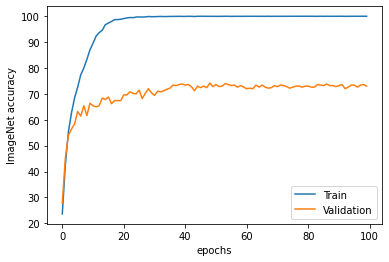

Use `print()` to show values.


In [ ]:
plt.figure()
plt.plot(np.arange(epochCount), trainStats.accuracies.makeNumpyArray(), label:"Train")
plt.plot(np.arange(epochCount), testStats.accuracies.makeNumpyArray(),  label:"Validation")
plt.xlabel("epochs")
plt.ylabel("ImageNet accuracy")
plt.legend(loc:"best")

plt.figure()
plt.plot(np.arange(epochCount), trainStats.averageLosses.makeNumpyArray(), label:"Train")
plt.plot(np.arange(epochCount), testStats.averageLosses.makeNumpyArray(),  label:"Validation")
plt.xlabel("epochs")
plt.ylabel("ImageNet loss")
plt.legend(loc:"best")
plt.show()

In [ ]:
print("Average epoch train time: ", trainStats.avgEpochTrainTime)

Average epoch train time:  288.58390020012854
